In [28]:
# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

# Machine learning
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
from rasterio.transform import from_origin

import matplotlib.pyplot as plt
from matplotlib import colors

# System utilities
import os
import joblib

from pygam import LinearGAM

In [29]:
def normalized_gini(y_pred, y_true):
    """
    Computes the normalized Gini coefficient.

    Parameters:
    -----------
    y_pred : array-like
        The predicted values (e.g., model predictions).
    y_true : array-like
        The true target values.

    Returns:
    --------
    float
        The normalized Gini coefficient.
    """
    def sum_gini(a_pred, a_true):
        # Sort true values by descending predicted values
        order = np.argsort(-a_pred)
        a_true_sorted = a_true[order]
        
        # Construct the random cumulative array
        n = len(a_pred)
        random_cum = np.arange(1, n+1) / n
        
        # Calculate the Lorentz curve (cumulative) for the sorted true values
        lorentz = np.cumsum(a_true_sorted) / np.sum(a_true_sorted)
        
        # Gini is the area between the Lorentz curve and the uniform distribution
        return np.sum(lorentz - random_cum)

    return sum_gini(np.array(y_pred).astype(int), np.array(y_true).astype(int)) / sum_gini(np.array(y_true).astype(int), np.array(y_true).astype(int))

In [30]:

results_dir = f'results/optimization'

study = joblib.load(os.path.join(results_dir, "study.pkl"))
trial = study.best_trial

params = trial.params

params.update({
    'objective': 'tweedie',
    'metric': None,
    'random_state': 42,
    'n_jobs': 1,
    'verbosity': -1
})
#lidar-based target data
lidar_path = 'data/raster/lidar_products/2019_lidar_cover.tif'

#rap data (predictor)
rap_path = 'data/raster/rap/woody_cover_2019.tif'

#static terrain predictors
dem_path = 'data/raster/ned/ned.tif'
slope_path = 'data/raster/terrain/slope.tif'
hli_path = 'data/raster/terrain/hli.tif'
tpi_path = f'data/raster/terrain/tpi_{params["tpi_ngb"]}.tif'
twi_path = 'data/raster/terrain/twi.tif'
covertype_path = 'data/raster/terrain/covertype.tif'

#train sample locations
train_points_path = 'data/vector/train_points_with_folds.geojson'

gpd_train_points = gpd.read_file(train_points_path)

# Read raster data for all points first
with rasterio.open(lidar_path) as src:
    lidar = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(rap_path) as src:
    rap = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(dem_path) as src:
    dem = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(slope_path) as src:
    slope = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(hli_path) as src:
    hli = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(tpi_path) as src:
    tpi = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(twi_path) as src:
    twi = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(covertype_path) as src:
    covertype = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

Y = np.array(lidar)

# Create feature dataframe for all points
X = pd.DataFrame({
    'rap': rap,
    'dem': dem, 
    'slope': slope,
    'hli': hli,
    'tpi': tpi,
    'twi': twi,
})


In [31]:
def process_fold(fold, params, X, Y, gpd_train_points):  

    train_mask = (gpd_train_points['fold'] != fold)
    test_mask = (gpd_train_points['fold'] == fold)

    #extract idx col, apply test mask, and get values
    x_coords = gpd_train_points.loc[test_mask, 'geometry'].apply(lambda geom: (geom.x)).values
    y_coords = gpd_train_points.loc[test_mask, 'geometry'].apply(lambda geom: (geom.y)).values

    # Add tpi to the feature dataframe
    X_fold = X.copy()

    X_train = X_fold[train_mask]
    X_test = X_fold[test_mask]
    y_train = np.array(Y)[train_mask]
    y_test = np.array(Y)[test_mask]
    # Create the LightGBM model
    lgb_model = lgb.LGBMRegressor(**params)

     # Fit the LightGBM model
    lgb_model.fit(X_train, y_train)

    # 1. Predict with LightGBM on train and test sets
    lgb_train_preds = lgb_model.predict(X_train)
    lgb_test_preds = lgb_model.predict(X_test)

    # 2. Stack a GAM
    gam = LinearGAM(n_splines=params['n_splines'])
    gam.fit(lgb_train_preds.reshape(-1, 1), y_train)

    # 4. Predict with the GAM model
    final_preds = gam.predict(lgb_test_preds.reshape(-1, 1))
    final_preds = np.clip(final_preds, 0, 100)

    # 5. Evaluate the stacked model
    gini = normalized_gini(final_preds, y_test)
    r2 = r2_score(y_test, final_preds)
    mae = mean_absolute_error(y_test, final_preds)
    return gini, r2, mae, y_test, lgb_test_preds, final_preds, x_coords, y_coords, X_test['rap']

n_folds = 5

results = []
gini_scores = []
r2_scores = []
mae_scores = []

fold_results = joblib.Parallel(n_jobs=n_folds)(
    joblib.delayed(process_fold)(fold, params, X, Y, gpd_train_points)
    for fold in range(n_folds)
)
gini_scores.append(np.mean([giniscore for giniscore, r2score, maescore, y_test, lgb_preds, final_preds, x_coord, y_coord, rap in fold_results]))
r2_scores.append(np.mean([r2score for giniscore, r2score, maescore, y_test, lgb_preds, final_preds, x_coord, y_coord, rap in fold_results]))
mae_scores.append(np.mean([maescore for giniscore, r2score, maescore, y_test, lgb_preds, final_preds, x_coord, y_coord, rap in fold_results]))

for fold, (gini, r2, mae, y_test, lgb_preds, final_preds, x_coord, y_coord, rap) in enumerate(fold_results):
    results.append(pd.DataFrame({
        'fold': fold,
        'y_test': y_test,
        'y_pred': final_preds,
        'lgb_pred': lgb_preds,
        'x_coord': x_coord,
        'y_coord': y_coord,
        'rap': rap
    }))

test_df = pd.concat(results, ignore_index=True)
print(gini_scores)
print(r2_scores)
print(mae_scores)

[0.840936964293493]
[0.628614413813499]
[6.597099914103441]


/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_42919/2170154793.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


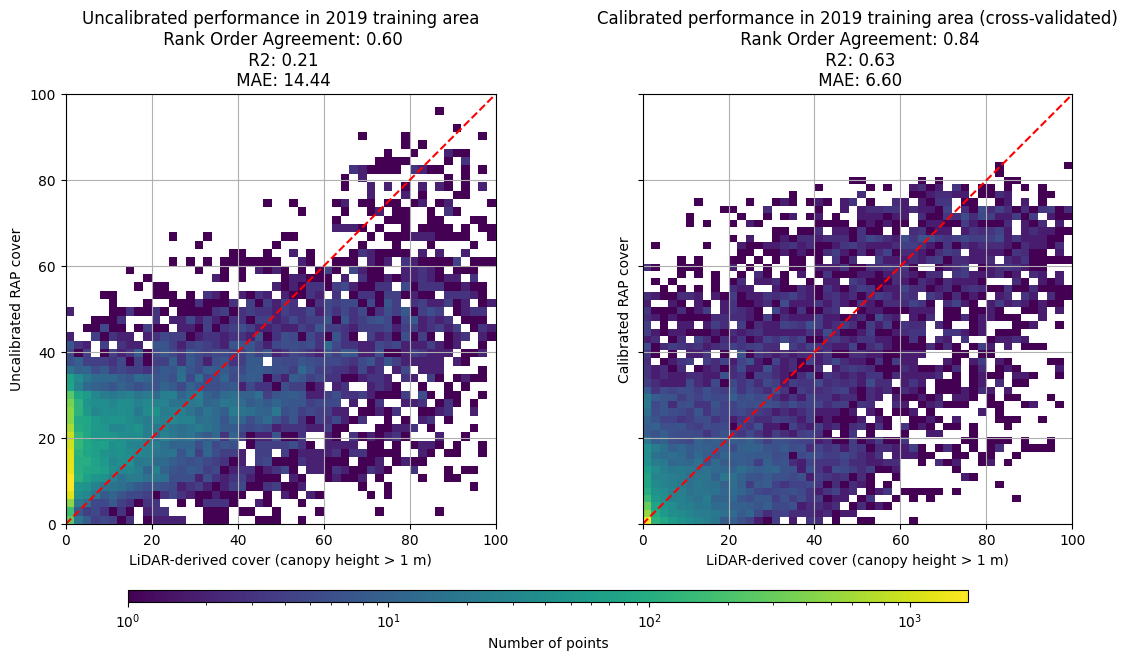

In [48]:
# Create the figure and axes for the two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

h0 = axes[0].hist2d(test_df['y_test'], test_df['rap'], bins=50, cmap='viridis', norm=colors.LogNorm())
gini_rap_lidar = normalized_gini(test_df['y_test'], test_df['rap'])
r2_rap_lidar = r2_score(test_df['y_test'], test_df['rap'])
mae_rap_lidar = mean_absolute_error(test_df['y_test'], test_df['rap'])
axes[0].set_xlabel(f'LiDAR-derived cover (canopy height > 1 m)')
axes[0].set_ylabel('Uncalibrated RAP cover')
axes[0].set_title(f'Uncalibrated performance in 2019 training area\n Rank Order Agreement: {gini_rap_lidar:.2f}\n R2: {r2_rap_lidar:.2f}\n MAE: {mae_rap_lidar:.2f}')
axes[0].grid(True)
min_val = min(min(test_df['y_test']), min(test_df['rap']))
max_val = max(max(test_df['y_test']), max(test_df['rap']))
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')
axes[0].set_aspect('equal', adjustable='box')

# Set axis limits to 100
axes[0].set_xlim(0, 100)
axes[0].set_ylim(0, 100)


# Create the scatter plot with reduced point size and increased transparency
h2 = axes[1].hist2d(test_df['y_test'], test_df['y_pred'], bins=50, cmap='viridis', norm=colors.LogNorm())

# Plot the 1 to 1 line
axes[1].plot([min(test_df['y_test']), max(test_df['y_test'])], [min(test_df['y_test']), max(test_df['y_test'])], 'r--')

# Set the aspect ratio to be equal
axes[1].set_aspect('equal', adjustable='box')

# Add labels and title
axes[1].set_xlabel('LiDAR-derived cover (canopy height > 1 m)')
axes[1].set_ylabel('Calibrated RAP cover')
axes[1].set_title(f'Calibrated performance in 2019 training area (cross-validated)\n Rank Order Agreement: {gini_scores[0]:.2f}\n R2: {r2_scores[0]:.2f}\n MAE: {mae_scores[0]:.2f}')

# Set axis limits to 100
axes[1].set_xlim(0, 100)
axes[1].set_ylim(0, 100)
axes[1].grid(True)

# Add a single colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])  # Reduced bottom position from 0.05 to 0.02
cbar = plt.colorbar(h0[3], cax=cbar_ax, orientation='horizontal')
cbar.set_label('Number of points')

# Show the plot
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Increase bottom margin to accommodate colorbar
path_to_true_v_pred = 'results/figures/training_true_v_pred.png'
plt.savefig(path_to_true_v_pred, dpi=300, bbox_inches='tight')
plt.show()


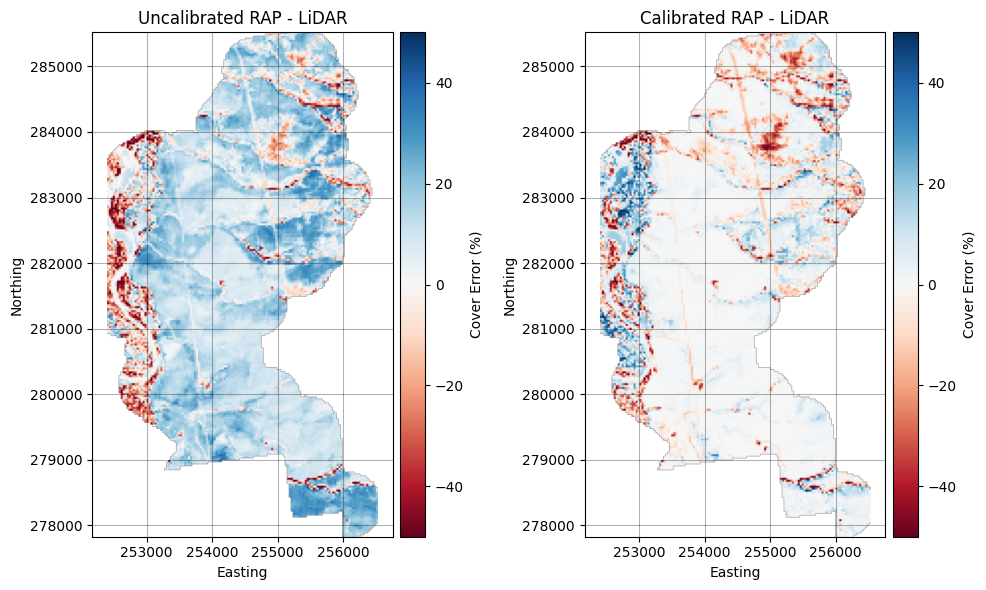

In [55]:
# Determine the bounds of the raster
min_easting, max_easting = min(test_df['x_coord']), max(test_df['x_coord'])
min_northing, max_northing = min(test_df['y_coord']), max(test_df['y_coord'])

# Define the resolution of the raster
resolution = 30  # Adjust as needed

# Calculate the number of rows and columns
width = int((max_easting - min_easting) / resolution)
height = int((max_northing - min_northing) / resolution)

# Create empty rasters with NaN values
raster_rap_error = np.full((height, width), np.nan)
raster_pred_error = np.full((height, width), np.nan)

# Rasterize the differences
for i, (x, y) in enumerate(zip(test_df['x_coord'], test_df['y_coord'])): 
    col = int((x - min_easting) / resolution)
    row = int((max_northing - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        # Access elements using the flattened index
        raster_rap_error[row, col] = test_df['rap'].iloc[i] - test_df['y_test'].iloc[i]
        raster_pred_error[row, col] = test_df['y_pred'].iloc[i] - test_df['y_test'].iloc[i]


# Create a binary map for the lowest error
raster_lowest_error = np.full((height, width), np.nan)
for i, (x, y) in enumerate(zip(test_df['x_coord'], test_df['y_coord'])): 
    col = int((x - min_easting) / resolution)
    row = int((max_northing - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        # Determine which method has the lowest absolute error
        if abs(raster_rap_error[row, col]) < abs(raster_pred_error[row, col]):
            raster_lowest_error[row, col] = 0  # 0 represents uncalibrated RAP
        else:
            raster_lowest_error[row, col] = 1  # 1 represents calibrated RAP

# Create masked arrays to handle NaN values for transparency
masked_raster_rap_error = np.ma.masked_invalid(raster_rap_error)
masked_raster_pred_error = np.ma.masked_invalid(raster_pred_error)
masked_raster_lowest_error = np.ma.masked_invalid(raster_lowest_error)

# Plot the rasters
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot the first raster (rap_test - y_test)
im1 = axes[0].imshow(masked_raster_rap_error, extent=(min_easting, max_easting, min_northing, max_northing), cmap='RdBu', vmin=-50, vmax=50)
axes[0].set_title('Uncalibrated RAP - LiDAR')
cbar1 = plt.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.02)
cbar1.set_label('Cover Error (%)')
axes[0].set_xlabel('Easting')
axes[0].set_ylabel('Northing')
axes[0].grid(True, color='black', alpha=0.3)

# Plot the second raster (y_pred - y_test)
im2 = axes[1].imshow(masked_raster_pred_error, extent=(min_easting, max_easting, min_northing, max_northing), cmap='RdBu', vmin=-50, vmax=50)
axes[1].set_title('Calibrated RAP - LiDAR')
cbar2 = plt.colorbar(im2, ax=axes[1], orientation='vertical', pad=0.02)
cbar2.set_label('Cover Error (%)')
axes[1].set_xlabel('Easting')
axes[1].set_ylabel('Northing')
axes[1].grid(True, color='black', alpha=0.3)

plt.subplots_adjust(wspace=0.4, hspace=0.1)  # Adjust wspace (width space) and hspace (height space)

# Set the same y-limits for all axes
axes[0].set_ylim(min_northing, max_northing)
axes[1].set_ylim(min_northing, max_northing)

# Set aspect ratio for all subplots to be equal
for ax in axes:
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()
path_to_error_maps = 'results/figures/training_error_maps.png'
plt.savefig(path_to_error_maps, dpi=300)
plt.show()



In [36]:
# Add tpi to the feature dataframe
X_production = X.copy()
Y_production = np.array(Y)

# Create the LightGBM model
lgb_production_mod = lgb.LGBMRegressor(**params)

lgb_production_mod.fit(X_production, Y_production)
lgb_pred_production = lgb_production_mod.predict(X_production)

gam = LinearGAM(n_splines=10)
gam.fit(lgb_pred_production.reshape(-1, 1), Y_production)

# 4. Predict with the GAM model
final_preds = gam.predict(lgb_pred_production.reshape(-1, 1))
final_preds = np.clip(final_preds, 0, 100)

#use joblib to dump lgb_production_mod and gam
os.makedirs('models/production', exist_ok=True)
joblib.dump(lgb_production_mod, 'models/production/lgb.pkl')
joblib.dump(gam, 'models/production/gam.pkl')

['models/production/gam.pkl']

/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_42919/3120744337.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels([0, 10, 20, 30, 40, '50+'])
/var/folders/vp/1c12nhtx09ng562vszvlczthvwd07y/T/ipykernel_42919/3120744337.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


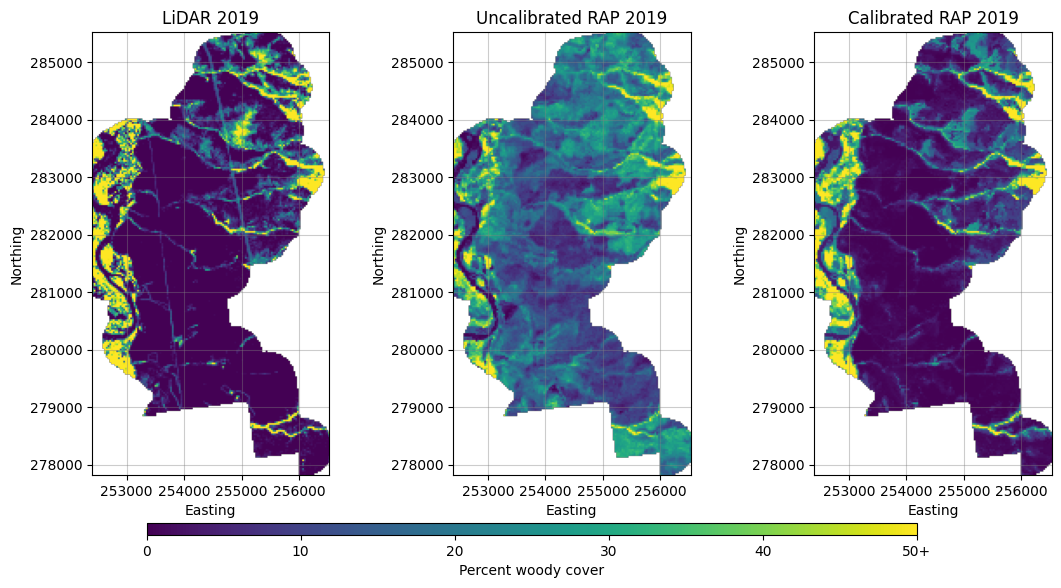

In [53]:
# Extract coordinates from the GeoDataFrame
x_coords = gpd_train_points['geometry'].apply(lambda geom: geom.x)
y_coords = gpd_train_points['geometry'].apply(lambda geom: geom.y)

coords = list(zip(x_coords, y_coords))

# Determine the bounds of the raster
min_x, max_x = min(x_coords), max(x_coords)
min_y, max_y = min(y_coords), max(y_coords)

# Define the resolution of the raster
resolution = 30  # Adjust as needed

# Calculate the number of rows and columns
width = int((max_x - min_x) / resolution)
height = int((max_y - min_y) / resolution)

# Create a transform for the raster
transform = from_origin(min_x, max_y, resolution, resolution)

# Create empty rasters with NaN values for each variable
raster_lidar = np.full((height, width), np.nan)
raster_rap = np.full((height, width), np.nan)
raster_calibrated = np.full((height, width), np.nan)

# Rasterize the values for each variable
for i, (x, y) in enumerate(coords):
    col = int((x - min_x) / resolution)
    row = int((max_y - y) / resolution)
    if 0 <= row < height and 0 <= col < width:
        raster_lidar[row, col] = np.clip(Y_production[i], 0, 100)
        raster_rap[row, col] = np.clip(X['rap'].iloc[i], 0, 100)
        raster_calibrated[row, col] = np.clip(final_preds[i], 0, 100)

# Create masked arrays
masked_lidar = np.ma.masked_invalid(raster_lidar)
masked_rap = np.ma.masked_invalid(raster_rap)
masked_calibrated = np.ma.masked_invalid(raster_calibrated)

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(11, 6))

# Plot each raster
im1 = axes[0].imshow(masked_lidar, extent=(min_x, max_x, min_y, max_y), cmap='viridis', vmin=0, vmax=50)
im2 = axes[1].imshow(masked_rap, extent=(min_x, max_x, min_y, max_y), cmap='viridis', vmin=0, vmax=50)
im3 = axes[2].imshow(masked_calibrated, extent=(min_x, max_x, min_y, max_y), cmap='viridis', vmin=0, vmax=50)

# Add titles and labels
axes[0].set_title('LiDAR 2019')
axes[1].set_title('Uncalibrated RAP 2019')
axes[2].set_title('Calibrated RAP 2019')

for ax in axes:
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_aspect('equal')
    ax.grid(True, color='grey', alpha=0.4)

# Add a single colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal', label='Percent woody cover')
cbar.ax.set_xticklabels([0, 10, 20, 30, 40, '50+'])

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
path_to_production_maps = 'results/figures/training_set_predictions.png'
plt.savefig(path_to_production_maps, dpi=300)
plt.show()
